In [ ]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

In [ ]:
if not os.path.exists('facial_keypoints.npz'):
  !wget -O facial_keypoints.npz "https://www.dropbox.com/scl/fi/27qggijmythfjg04s24xq/facial_keypoints.npz?rlkey=h91gwodhrfuz8hrc7ux9qnq7s&dl=1"

In [ ]:
data = np.load('facial_keypoints.npz')
images = data['images']
keypoints = data['keypoints']

Images - Shape: (7049, 1, 96, 96), Dtype: int64, Min: 0, Max: 255
Keypoints - Shape: (7049, 30), Dtype: float32, Min: 0.6865919828414917, Max: 95.9356460571289


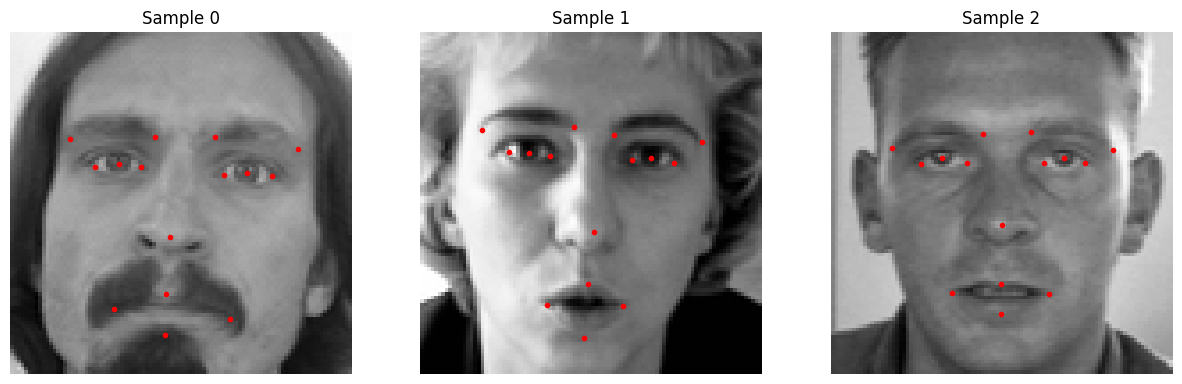

In [ ]:
# Print details
print(f"Images - Shape: {images.shape}, Dtype: {images.dtype}, Min: {np.nanmin(images)}, Max: {np.nanmax(images)}")
print(f"Keypoints - Shape: {keypoints.shape}, Dtype: {keypoints.dtype}, Min: {np.nanmin(keypoints)}, Max: {np.nanmax(keypoints)}")

# Show some images with keypoints
num_samples_to_show = 3
fig, axes = plt.subplots(1, num_samples_to_show, figsize=(15, 5))

for i in range(num_samples_to_show):
    img = images[i].squeeze()  # Shape: (height, width)
    kp = keypoints[i].reshape(-1, 2)  # Shape: (num_keypoints, 2)

    # Plot image
    axes[i].imshow(img, cmap='gray')

    # Plot keypoints
    axes[i].plot(kp[:, 0], kp[:, 1], 'r.')  # Red dots for keypoints
    axes[i].set_title(f"Sample {i}")
    axes[i].axis("off")

plt.show()

In [ ]:

# 2. Preprocess and Split data

images_tensor = torch.tensor(images, dtype=torch.float32)  # Convert to tensor
keypoints_tensor = torch.tensor(keypoints, dtype=torch.float32)  # Convert keypoints

images_tensor /= 255 # Normalize values between 0 and 1
keypoints_tensor /= 96 # Normalize values between 0 and 1

In [ ]:
# Prepare a 90/10 train/test split
import sklearn
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(images_tensor, keypoints_tensor, random_state=0, train_size = .9)

In [ ]:
# 3. Prepare Dataset and DataLoader objects.
batch = 32

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=False)


In [ ]:
device = 'cuda'

In [ ]:
# 4. Create a CNN
cnn_model = torch.nn.Sequential(

    # Conv 1
    # Greyscale of 1 in channel
    torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),

    # Conv 2
    torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),

    # Pool 1
    torch.nn.MaxPool2d(kernel_size=2, stride=2),

    # Conv 3
    torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),

    # Conv 4
    torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),

    # Pool 2
    torch.nn.MaxPool2d(kernel_size=2, stride=2),

    # Conv 5
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),

    # Conv 6
    torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),

    # Pool 3
    torch.nn.MaxPool2d(kernel_size=2, stride=2),

    # Flatten
    torch.nn.Flatten(),

    # Fully Connected (FN) Layers
    torch.nn.Linear(in_features=32 * 12 * 12, out_features=4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(in_features=4096, out_features=4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(in_features=4096, out_features=30),

).to(device)



In [ ]:
def masked_mae_loss(y_pred,y_true):
    mask = 1-torch.isnan(y_true).float()
    diff = torch.abs(y_true-y_pred)
    return torch.nansum(diff*mask)/torch.nansum(mask)

# Create a cross-entropy loss function and a stochastic gradient descent (SGD) optimizer
lr = 1e-5
opt = torch.optim.Adam(cnn_model.parameters(), lr=lr, weight_decay=0.0001)

In [ ]:
# 5. Train the Model
epochs = 100
cnn_model.train()  # Set the model to training mode

for epoch in range(epochs):
    total_loss = 0
    for batch_X, batch_y in train_dataloader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Make sure the input has the correct shape (batch_size, 1, height, width)
        if len(batch_X.shape) == 3:
            batch_X = batch_X.unsqueeze(1)  # Add channel dimension (1)

        opt.zero_grad()  # Zero out gradients

        # Forward pass
        z = cnn_model(batch_X)

        # Compute loss
        loss = masked_mae_loss(z, batch_y)

        # Backpropagation
        loss.backward()

        torch.nn.utils.clip_grad_norm_(cnn_model.parameters(), max_norm=1.0)

        # Apply gradients
        opt.step()

        # Accumulate loss
        total_loss += loss.item()

    # Print out the loss for the current epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_dataloader):.4f}")


Epoch 1/100, Loss: 0.1647
Epoch 2/100, Loss: 0.0500
Epoch 3/100, Loss: 0.0469
Epoch 4/100, Loss: 0.0453
Epoch 5/100, Loss: 0.0440
Epoch 6/100, Loss: 0.0426
Epoch 7/100, Loss: 0.0419
Epoch 8/100, Loss: 0.0411
Epoch 9/100, Loss: 0.0401
Epoch 10/100, Loss: 0.0396
Epoch 11/100, Loss: 0.0391
Epoch 12/100, Loss: 0.0387
Epoch 13/100, Loss: 0.0382
Epoch 14/100, Loss: 0.0378
Epoch 15/100, Loss: 0.0377
Epoch 16/100, Loss: 0.0372
Epoch 17/100, Loss: 0.0368
Epoch 18/100, Loss: 0.0366
Epoch 19/100, Loss: 0.0363
Epoch 20/100, Loss: 0.0362
Epoch 21/100, Loss: 0.0358
Epoch 22/100, Loss: 0.0358
Epoch 23/100, Loss: 0.0353
Epoch 24/100, Loss: 0.0353
Epoch 25/100, Loss: 0.0350
Epoch 26/100, Loss: 0.0349
Epoch 27/100, Loss: 0.0347
Epoch 28/100, Loss: 0.0346
Epoch 29/100, Loss: 0.0347
Epoch 30/100, Loss: 0.0341
Epoch 31/100, Loss: 0.0340
Epoch 32/100, Loss: 0.0338
Epoch 33/100, Loss: 0.0338
Epoch 34/100, Loss: 0.0338
Epoch 35/100, Loss: 0.0335
Epoch 36/100, Loss: 0.0335
Epoch 37/100, Loss: 0.0333
Epoch 38/1

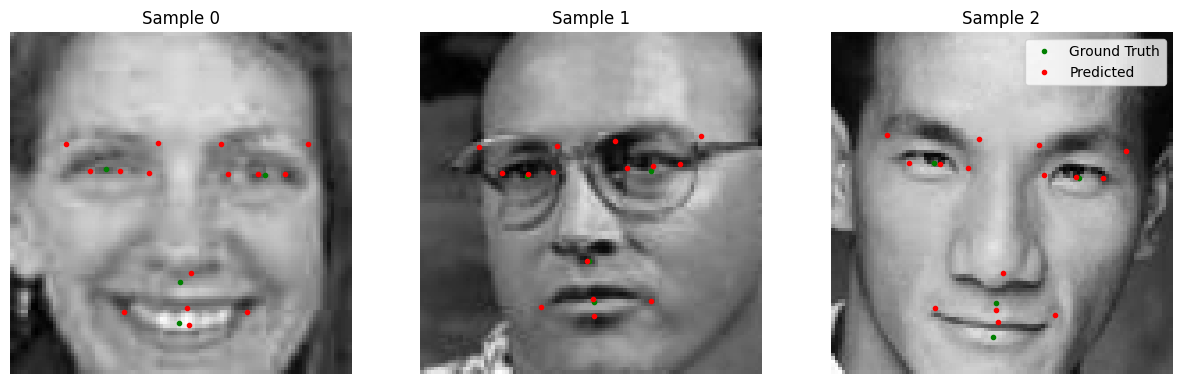

In [ ]:
# Analyze the Results
num_samples_to_show = 3
fig, axes = plt.subplots(1, num_samples_to_show, figsize=(15, 5))

cnn_model.eval()  # Set model to evaluation mode

for i in range(num_samples_to_show):
    img = X_test[i].unsqueeze(0).to(device)  # Add batch dimension and move to GPU
    true_kp = y_test[i].cpu().numpy().reshape(-1, 2) * 96  # Rescale keypoints

    with torch.no_grad():
      pred_kp = cnn_model(img).cpu().numpy().reshape(-1, 2) * 96  # Ensure correct shape

    # Plot image
    axes[i].imshow(img.cpu().squeeze(), cmap='gray')

    # Plot ground truth keypoints
    axes[i].plot(true_kp[:, 0], true_kp[:, 1], 'g.', label="Ground Truth")  # Green for true keypoints

    # Plot predicted keypoints
    axes[i].plot(pred_kp[:, 0], pred_kp[:, 1], 'r.', label="Predicted")  # Red for predicted keypoints

    axes[i].set_title(f"Sample {i}")
    axes[i].axis("off")

plt.legend()
plt.show()


In [ ]:
def compute_pixel_error(y_pred, y_true):
    mask = 1 - torch.isnan(y_true).float()
    diff = torch.abs(y_true - y_pred)
    pixel_mae = torch.nansum(diff * mask) / torch.nansum(mask)
    return pixel_mae.item() * 96  # Scale back to pixel space

# Compute error on test set
cnn_model.eval()
y_pred = cnn_model(X_test.to(device)).cpu()
test_error = compute_pixel_error(y_pred, y_test)
train_error = compute_pixel_error(cnn_model(X_train.to(device)).cpu(), y_train)

print(f"Test MAE: {test_error:.2f} pixels")
print(f"Train MAE: {train_error:.2f} pixels")



Test MAE: 2.00 pixels
Train MAE: 1.97 pixels
